In [1]:
!pip install caer canaro

     |████████████████████████████████| 814 kB 4.3 MB/s 
     |████████████████████████████████| 55.7 MB 31.2 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc # garbage collection

In [3]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [4]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [5]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [6]:
# Create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
1 - homer_simpson
2 - homer_simpson
3 - homer_simpson
4 - homer_simpson
5 - homer_simpson
6 - homer_simpson
7 - homer_simpson
8 - homer_simpson
9 - homer_simpson
10 - homer_simpson
11 - homer_simpson
12 - homer_simpson
13 - homer_simpson
14 - homer_simpson
15 - homer_simpson
16 - homer_simpson
17 - homer_simpson
18 - homer_simpson
19 - homer_simpson
20 - homer_simpson
21 - homer_simpson
22 - homer_simpson
23 - homer_simpson
24 - homer_simpson
25 - homer_simpson
26 - homer_simpson
27 - homer_simpson
28 - homer_simpson
29 - homer_simpson
30 - homer_simpson
31 - homer_simpson
32 - homer_simpson
33 - homer_simpson
34 - homer_simpson
35 - homer_simpson
36 - homer_simpson
37 - homer_simpson
38 - homer_simpson
39 - homer_simpson
40 - homer_simpson
41 - homer_simpson
42 - homer_simpson
43 - homer_simpson
44 - homer_simpson
45 - homer_simpson
46 - homer_simpson
47 - homer_simps

In [7]:
len(train)

13811

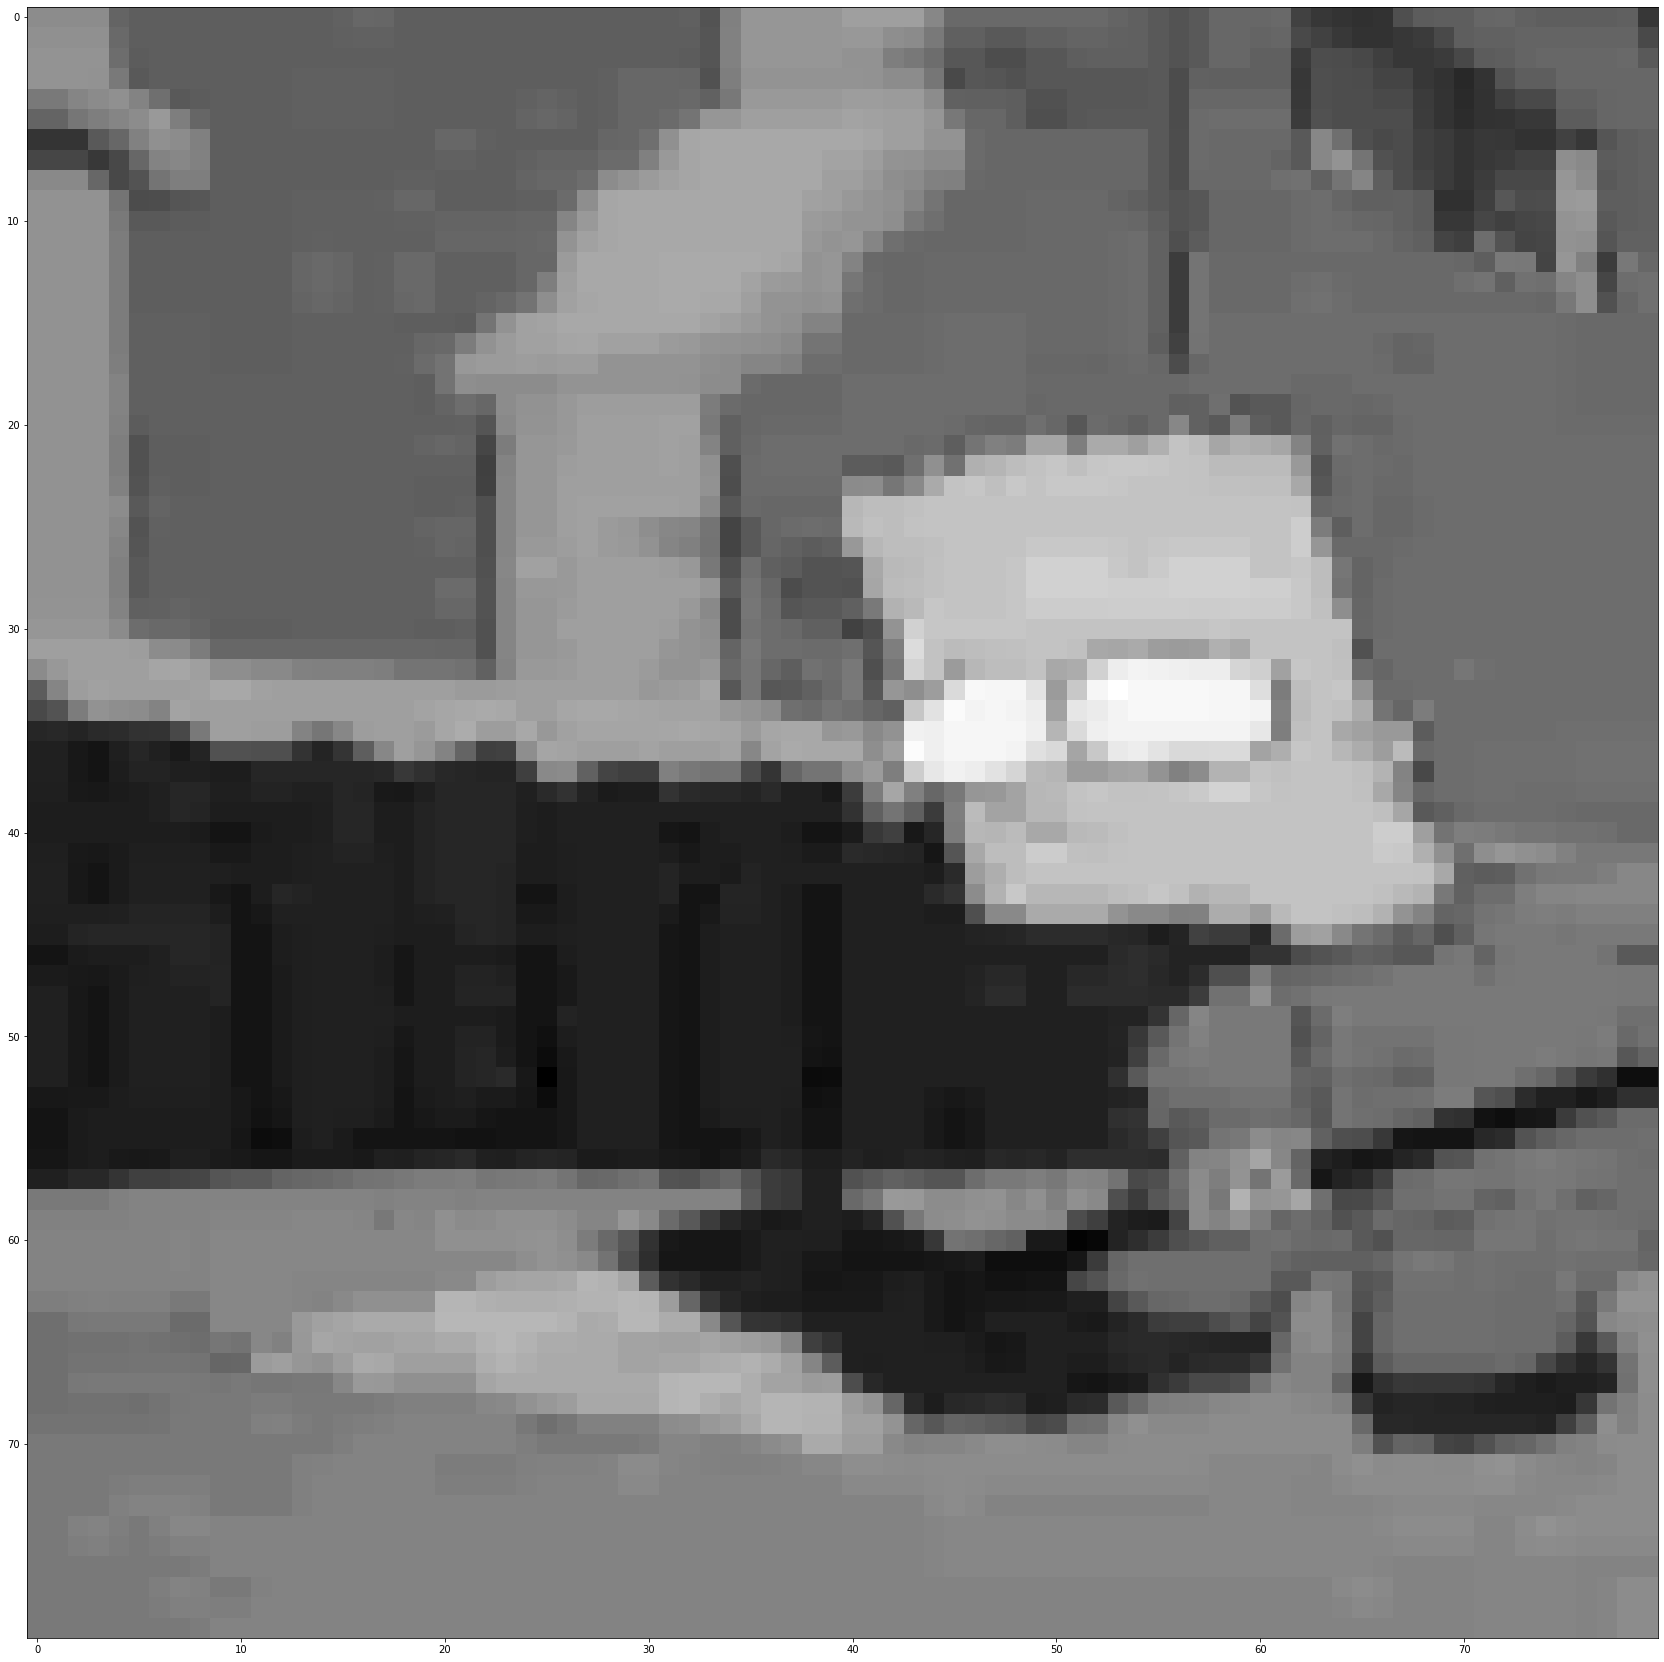

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [9]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [10]:
from tensorflow.keras.utils import to_categorical
# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [11]:
!pip install scikit-learn
!pip show scikit-learn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Name: scikit-learn
Version: 0.23.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /opt/conda/lib/python3.7/site-packages
Requires: scipy, threadpoolctl, numpy, joblib
Required-by: yellowbrick, Wordbatch, wfdb, vecstack, umap-learn, tsfresh, TPOT, sklearn, sklearn-pandas, sklearn-contrib-py-earth, shap, scikit-plot, scikit-optimize, scattertext, rgf-python, pysal, PDPbox, nilearn, mlxtend, mapclassify, lime, lightgbm, lightfm, librosa, kmodes, kmapper, keras-tuner, imbalanced-learn, hypertools, hpsklearn, hmmlearn, hep-ml, gplearn, fastai, fancyimpute, eli5, chainer-chemistry, cesium, category-encoders, catalyst, Boruta, bayesian-optimization, autogluon.core, allennlp


In [12]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)
# 80% of data goes to training set, 20% goes to validation set

In [13]:
del train
del featureSet
del labels
gc.collect()

2581

In [14]:
BATCH_SIZE=32
EPOCHS=10

In [15]:
# Image data generator
# Synthesize new images from existing ones to introduce randomness and increase performance
datagen = canaro.generators.imageDataGenerator()
x_train = np.array(x_train)
y_train = np.array(y_train)
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [16]:
!pip install --upgrade canaro

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [17]:
# Creating the model
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters), 
                                         loss='binary_crossentropy', decay=1e-7, learning_rate=0.001, momentum=0.9,
                                         nesterov=True)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)       

In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
x_val = np.array(x_val)
y_val = np.array(y_val)
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 [==============================] - 363s 1s/step - loss: 0.3223 - accuracy: 0.1620 - val_loss: 0.3219 - val_accuracy: 0.1501
Epoch 2/10
345/345 [==============================] - 346s 1s/step - loss: 0.3170 - accuracy: 0.1798
Epoch 3/10
345/345 [==============================] - 344s 996ms/step - loss: 0.3078 - accuracy: 0.2281
Epoch 4/10
345/345 [==============================] - 345s 1000ms/step - loss: 0.3037 - accuracy: 0.2424
Epoch 5/10
345/345 [==============================] - 345s 1s/step - loss: 0.3026 - accuracy: 0.2476
Epoch 6/10
345/345 [==============================] - 345s 1s/step - loss: 0.3007 - accuracy: 0.2618
Epoch 7/10
345/345 [==============================] - 348s 1s/step - loss: 0.2986 - accuracy: 0.2696
Epoch 8/10
345/345 [==============================] - 346s 1s/step - loss: 0.2960 - accuracy: 0.2825
Epoch 9/10
345/345 [==============================] - 361s 1s/step - loss: 0.2933 - accuracy: 0.2874
Epoch 10/10
345/345 [=====================

In [20]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

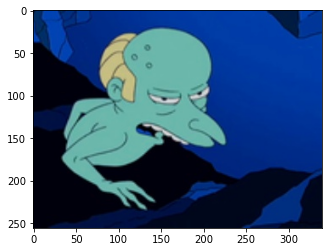

In [21]:
test_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset/charles_montgomery_burns/pic_0000.jpg'
img = cv.imread(test_path)
plt.imshow(img)
plt.show()

In [22]:
def prepare(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, channels=1)
    return img

In [23]:
predictions = model.predict(prepare(img))

In [24]:
print(characters[np.argmax(predictions[0])])

charles_montgomery_burns
